# 00. Homework description

For this assignment, your task is to develop the [FastPitch](https://arxiv.org/abs/2006.06873) synthesis model, train it, and generate several audio samples.

The training and data processing code has already been provided for you. The training will be conducted on the LJspeech dataset.

The total score for the homework is **10 points**, distributed as follows:
- 1 point for visualizing the input data
- 8 points for writing the model code and running training
- 1 point for pitch and duration manipulations during inference

The homework submission **should include**:
- Completed notebook
- Attached WER and loss graphs from TensorBoard
- 1 audio file - the result of a regular model inference
- 4 additional audio files: you are encouraged to experiment with adjusting phoneme durations and pitch slightly and listen to the results.

# 01. Preparation steps

In [1]:
device = "cuda"
gpu_avaiable = "1"    # Run nvidia-smi to find free GPU

In [2]:
path_to_sources = "./"   # Path to the the current week's source code, e.g. /home/user/speech_course/week_08_tts_am_vocoders

In [3]:
# If running in colab

# clone the repository:
# git clone https://github.com/yandexdataschool/speech_course.git
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Dataset

We will work with [LJSpeech](https://keithito.com/LJ-Speech-Dataset/) -- a single-speaker dataset with 24 hours of speech.

The data we will use contains pre-computed [MFA-alignments](https://montreal-forced-aligner.readthedocs.io/en/latest/user_guide/workflows/alignment.html) alongside with the original wavs and texts. If you are interested in the process of extracting such alignments, please refer to this [tutorial](https://colab.research.google.com/gist/NTT123/12264d15afad861cb897f7a20a01762e/mfa-ljspeech.ipynb).

Download the dataset with precomputed alignments.

In [3]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/PpgePfWcQTAbug'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

path_to_dataset = 'data/ljspeech'    # Choose any appropriate local path

# If running in Colab:
# path_to_dataset = '/content/ljspeech_aligned'

zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=path_to_dataset)

KeyboardInterrupt: 

### Hi-Fi GAN checkpoint


Download a pretrained Hi-Fi GAN checkpoint (to generate audio from the predicted mel-spectrograms).

In [4]:
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/dle/hifigan__pyt_ckpt_ds-ljs22khz/versions/21.08.0_amp/zip -O hifigan_ckpt.zip
!unzip hifigan_ckpt.zip
!rm hifigan_ckpt.zip

--2025-04-27 18:29:28--  https://api.ngc.nvidia.com/v2/models/nvidia/dle/hifigan__pyt_ckpt_ds-ljs22khz/versions/21.08.0_amp/zip
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 35.80.217.222, 52.25.173.221
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|35.80.217.222|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xfiles.ngc.nvidia.com/org/nvidia/team/dle/models/hifigan__pyt_ckpt_ds-ljs22khz/versions/21.08.0_amp/files.zip?ssec-algo=AES256&ssec-key=uImygRnwdDJIGajq%2BjrLPfMgIIsUGrxGU6fXZERcCGN6yAwptHyi9x%2BO%2F1faXjaoWf83nwJEYppEJq2zOC3pa22F41HekmjsbXxKvxBLaOIom86ujiNHX43U4qWMLWrUeKWmKqSFjC7wyjsyy%2FZ4JVMKgH%2BkwWsp51DedOmKs33APVPr1bpId6S43mF%2Bmrs5wVmtUaOrUZWvsHTaiCNsN0TMN5186dxq7PxTf8P8gkYdz2DUxUPwgmT5l76j13fRDjbFQr9oYUxRz9cljf%2BlAZYy3HwJSueM2LFn7wbt502aKEFDjBCUdtL3sRPUQliTrmijV2aUsqCQ%2B62ccJskm0b5GLgZbeu1v9HkbXG0H1Ipf6igahRO%2BTri10jbCRYmc8InfcwZ8B8HFgMuLUwH1Br9IEExjlRZrHSU%2FkJ%2BjTSSWIcFCnPYuew6JiTOSr1fHNKB8y%2BzXnO13o3Q3ziivL8Kgqv

Archive:  hifigan_ckpt.zip


replace hifigan_gen_checkpoint_6500.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


Exception: Process exited with code 1

In [ ]:
# In colab:
# !wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/dle/hifigan__pyt_ckpt_ds-ljs22khz/versions/21.08.0_amp/zip -O /content/hifigan_ckpt.zip
# !unzip /content/hifigan_ckpt.zip
# !rm /content/hifigan_ckpt.zip

In [3]:
path_to_hfg_ckpt = "hifigan_gen_checkpoint_6500.pt" 
path_to_dataset = 'data/ljspeech' 

### Imports

In [4]:
import sys
import os
import json
import dataclasses
import torch
import subprocess as sp
import matplotlib.pylab as plt
import soundfile as sf

from g2p_en import G2p
import IPython.display as Ipd

In [5]:
sys.path.append(path_to_sources)

# 02. See a data sample (1 point)

In [6]:
from sources.fastpitch.hparams import HParamsFastpitch
from sources.fastpitch.data import prepare_loaders, SymbolsSet

The mfa alignment provides phonemes and their durations, which we will need during training:

In [7]:
with open(os.path.join(path_to_dataset, 'mfa_aligned', 'LJ001-0001.json')) as f:
    utterance = json.load(f)

utterance

{'start': 0,
 'end': 9.655062,
 'tiers': {'words': {'type': 'interval',
   'entries': [[0.0, 0.69, 'printing'],
    [0.69, 0.82, '<eps>'],
    [0.82, 1.01, 'in'],
    [1.01, 1.15, 'the'],
    [1.15, 1.45, 'only'],
    [1.45, 1.97, 'sense'],
    [1.97, 2.14, 'with'],
    [2.14, 2.39, 'which'],
    [2.39, 2.54, 'we'],
    [2.54, 2.71, 'are'],
    [2.71, 2.89, 'at'],
    [2.89, 3.28, 'present'],
    [3.28, 4.0, 'concerned'],
    [4.0, 4.41, '<eps>'],
    [4.41, 5.01, 'differs'],
    [5.01, 5.04, '<eps>'],
    [5.04, 5.28, 'from'],
    [5.28, 5.65, 'most'],
    [5.65, 5.82, 'if'],
    [5.82, 6.1, 'not'],
    [6.1, 6.29, 'from'],
    [6.29, 6.63, 'all'],
    [6.63, 6.78, 'the'],
    [6.78, 7.09, 'arts'],
    [7.09, 7.22, 'and'],
    [7.22, 7.8, 'crafts'],
    [7.8, 8.45, 'represented'],
    [8.45, 8.66, 'in'],
    [8.66, 8.79, 'the'],
    [8.79, 9.6, 'exhibition'],
    [9.6, 9.655062, '<eps>']]},
  'phones': {'type': 'interval',
   'entries': [[0.0, 0.04, 'P'],
    [0.04, 0.07, 'R'],
    [0

Phoneme `sil` here denotes pause -- a period of silence between spoken phonemes. The phonemes are from [ARPA](https://en.wikipedia.org/wiki/ARPABET) alphabet.

In [8]:
hparams = HParamsFastpitch()
symbol_set = SymbolsSet()
train_loader, val_loader = prepare_loaders(path_to_dataset, hparams)

In [9]:
train_iter = iter(train_loader)
batch = next(train_iter)

In [10]:
list(dataclasses.asdict(batch).keys())

['texts',
 'text_lengths',
 'mels',
 'mel_lengths',
 'pitches',
 'durations',
 'paces']

In [11]:
batch.mels.shape

torch.Size([10, 80, 822])

In [12]:
batch.mels[9, :, 450:]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [13]:
batch.pitches.shape

torch.Size([10, 112])

In [14]:
batch.pitches[0]

tensor([ 0.1838,  0.1574,  0.0000, -0.2824, -0.3209,  0.4885,  2.2358,  1.6571,
        -0.2517,  0.2428, -0.0644, -0.5365, -0.9021, -0.9422,  0.0000,  0.6490,
         0.6153,  0.0285,  0.0261, -0.5102, -0.2863, -0.1551, -0.6124,  0.8327,
         0.0000, -0.0887, -0.2179, -0.4179, -0.0883,  0.1657,  0.9257,  1.8013,
         0.0000,  0.0000, -0.7734, -0.2031,  0.7624,  1.1786,  0.0792, -0.5318,
        -1.0540, -0.6174,  0.5000,  0.5903,  0.0000, -0.0063,  0.0000,  0.0000,
         1.0168,  3.3467,  2.5731,  0.7877,  1.5515,  1.1189,  1.0121,  0.9642,
         0.4310, -0.3602, -0.5691, -0.3506, -0.0179,  0.0000, -0.3070, -0.6476,
         0.0000,  0.1668,  0.0366, -0.1890, -0.9703, -0.9492, -0.4212, -0.2789,
        -0.3735, -0.4660, -0.7748, -1.0651, -0.9768,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [15]:
batch.texts[0]

tensor([ 4, 31, 56, 25, 33, 35, 67, 20, 23, 57, 34, 44, 21,  6, 31, 10, 53, 56,
        38, 44, 29, 56, 37, 67, 69, 10, 53,  4, 56, 42, 38, 54, 56, 18, 16, 31,
        10, 53, 56, 38, 44, 44, 16, 44, 56, 37, 69, 52, 53, 35, 44, 56, 34, 45,
        34, 44, 64, 23, 44, 34, 54, 33,  4, 20, 20, 34, 41, 42, 16, 44, 20, 64,
        23, 53, 37, 43,  7, 19, 69,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0])

In [16]:
batch.text_lengths[0]

tensor(79)

## Task

**(0.5 points)** Draw a combined image showing both the mel-spectrogram and pitch for a sample from the batch. Use durations to ensure proper alignment of their shapes in the image.  
**(0.5 points)** Include phoneme labels near the time axis on the image from the previous step. (like in Figure 3 in the [paper](https://arxiv.org/pdf/2006.06873.pdf)). You may find the code from the seminar helpful.

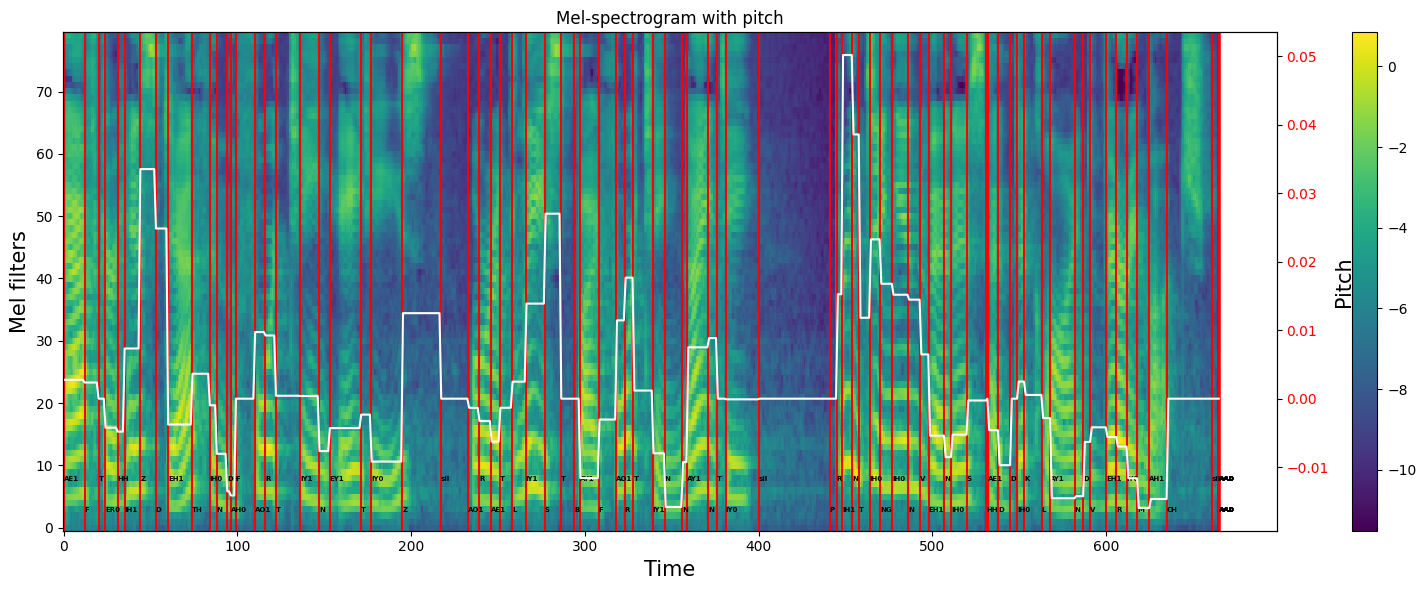

In [17]:
import numpy as np
import librosa

def hertz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def plot_spectrogram_with_phonemes(mel, pitch, durations, phonemes, title="Mel-spectrogram with pitch"):
    durations_cs = np.hstack([[0], durations.cumsum()])
    total_duration = durations_cs[-1]
    pitch_repeated = librosa.hz_to_mel(torch.repeat_interleave(torch.tensor(pitch), torch.tensor(durations)))
    
    fig, ax1 = plt.subplots(figsize=(16, 6))
    im = ax1.imshow(mel[:, :total_duration], aspect='auto', origin='lower', interpolation='none')
    ax1.set_ylabel('Mel filters', fontsize=15)
    ax1.set_xlabel('Time', fontsize=15)
    plt.title(title)
    plt.colorbar(im, ax=ax1)

    ax2 = ax1.twinx()
    ax2.plot(np.linspace(0, total_duration, len(pitch_repeated)), pitch_repeated, color='w', label='Pitch')
    ax2.set_ylabel('Pitch', fontsize=15)
    ax2.tick_params(axis='y', labelcolor='r')

    for i, s in enumerate(durations_cs[:-1]):
        shift = -5 if i % 2 else -15
        ax1.text(
            s, shift * ax1.get_ylim()[0],# * 20,
            phonemes[i],
            fontsize=5,
            weight='bold'
        )

    for s in durations_cs:
        ax1.axvline(x=s, c='r')

    plt.tight_layout()
    plt.show()


phonemes = symbol_set.decode(batch.texts[0].detach().numpy())

mel_sample = batch.mels[0].detach().numpy()
pitch_sample = batch.pitches[0].detach().numpy()
durations_sample = batch.durations[0].detach().numpy()

plot_spectrogram_with_phonemes(mel_sample, pitch_sample, durations_sample, phonemes)

# 03. Implement FastPitch model (9 points)

Please implement the FastPitch model in the cell provided below. Running this cell will overwrite the model file in the repository. 
- Run training (see next cells)
- Run inference (see next cells)
- When submitting the homework, please include
   - the Word Error Rate (WER) and loss curves obtained from TensorBoard as attachments,
   - the generated audio (see inference cells). If attaching an archive, use the name: `prediction.wav`

By the end of training, the loss should reach approximately 0.69, and WER should be close to zero (around 0.006). The training process will take about 30 minutes (3,000 batches).

**Important:** By the end of the training, the generated audio sample must be clear in terms of speech (WER close to 0) and maintain audio quality comparable to the original recordings (as logged in TensorBoard). **If these conditions are not met, the entire section will receive zero points**, regardless of how closely the model code resembles working code. Here is an example of how an audio from a well-trained model may sound:

In [18]:
audio, sr = sf.read('prediction_example.wav')
Ipd.display(Ipd.Audio(audio, rate=sr))

In [19]:
%%writefile sources/fastpitch/model.py

import torch
from torch import nn as nn

from sources.fastpitch.common.layers import TemporalPredictor
from sources.fastpitch.common.utils import DeviceGetterMixin
from sources.fastpitch.common.utils import regulate_len
from sources.fastpitch.data import FastPitchBatch, SymbolsSet
from sources.fastpitch.hparams import HParamsFastpitch
from sources.fastpitch.common.transformer import FFTransformer


class FastPitch(nn.Module, DeviceGetterMixin):
    def __init__(self, hparams: HParamsFastpitch):
        super().__init__()
        self.hparams = hparams
        n_symbols = len(SymbolsSet().symbols_to_id)

        self.symbol_emb = nn.Embedding(n_symbols, hparams.symbols_embedding_dim)

        self.encoder = FFTransformer(
            n_layer=hparams.in_fft_n_layers,
            n_head=hparams.in_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.in_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.in_fft_conv1d_kernel_size,
            dropout=hparams.p_in_fft_dropout,
            dropatt=hparams.p_in_fft_dropatt,
            dropemb=hparams.p_in_fft_dropemb
        )

        self.duration_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.dur_predictor_filter_size,
            kernel_size=hparams.dur_predictor_kernel_size,
            dropout=hparams.p_dur_predictor_dropout,
            n_layers=hparams.dur_predictor_n_layers
        )

        self.pitch_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.pitch_predictor_filter_size,
            kernel_size=hparams.pitch_predictor_kernel_size,
            dropout=hparams.p_pitch_predictor_dropout,
            n_layers=hparams.pitch_predictor_n_layers
        )

        self.pitch_emb = nn.Conv1d(1, hparams.symbols_embedding_dim, kernel_size=3, padding=1)

        self.decoder = FFTransformer(
            n_layer=hparams.out_fft_n_layers,
            n_head=hparams.out_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.out_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.out_fft_conv1d_kernel_size,
            dropout=hparams.p_out_fft_dropout,
            dropatt=hparams.p_out_fft_dropatt,
            dropemb=hparams.p_out_fft_dropemb
        )

        self.proj = nn.Linear(hparams.symbols_embedding_dim, hparams.n_mel_channels, bias=True)

    def get_encoder_out(self, batch: FastPitchBatch):
        '''
        Return: 
        enc_out: 
            Output of the first series of FFT blocks (before adding pitch embedding)
            shape: (batch, len(text), symbols_embedding_dim)
        enc_mask:
            Boolean padding mask for the input text sequences
            shape: (batch, len(text), 1)
        '''
        symb_emb = self.symbol_emb(batch.texts)
        enc_out, enc_mask = self.encoder(symb_emb, batch.text_lengths)
        return enc_out, enc_mask

    def forward(self, batch: FastPitchBatch, use_gt_durations=True, use_gt_pitch=True, max_duration=75):
        '''
        Flags `use_gt_durations` and `use_gt_pitch` should be both True during training and either True or False during inference.

        Use the function `regulate_len` to duplicate phonemes according to durations before passing them to the decoder.
        
        Return:
        mel_out:
            Predicted mel-spectrograms
            shape: (batch, time, mel_bins)
        mel_lens:
            Number of time frames in each of the predicted spectrograms
            shape: (batch,)
        log_dur_pred:
            The predicted log-durations for each phoneme (the output of the duration predictor).
            shape: (batch, len(text))
        dur_pred:
            The exponent of the predicted log-durations for each phoneme. Clamped to the range (0, max_duration) for numeric stability
            shape: (batch, len(text))
        pitch_pred:
            The predicted pitch for each phoneme
            shape: (batch, len(text))
        '''
        enc_out, enc_mask = self.get_encoder_out(batch)
        
        log_dur_pred = self.duration_predictor(enc_out, enc_mask)
        dur_pred = torch.clamp(torch.exp(log_dur_pred) - 1, 0, max_duration)
        if use_gt_durations:
            durations = batch.durations
        else:
            durations = dur_pred

        pitch_pred = self.pitch_predictor(enc_out, enc_mask).unsqueeze(1)
        if use_gt_pitch:
            pitch = batch.pitches.unsqueeze(1)
        else:
            pitch = pitch_pred

        enc_out = enc_out + self.pitch_emb(pitch).transpose(1, 2)

        enc_rep, mel_lens, _ = regulate_len(durations, enc_out, batch.paces)

        dec_out, dec_mask = self.decoder(enc_rep, mel_lens)

        mel_out = self.proj(dec_out)
        # log_dur_tgt = torch.log(batch.durations.float() + 1)
        # print(log_dur_tgt.shape)
        # print(log_dur_pred.shape)
        # print("log_target: ", log_dur_tgt, "log_pred: ", log_dur_pred)
        # print("target: ", batch.durations, "pred: ", dur_pred)
        return mel_out, mel_lens, dur_pred, log_dur_pred, pitch_pred.squeeze(1)

    @torch.no_grad()
    def infer(self, batch: FastPitchBatch, max_duration=75):
        enc_out, dur_pred, pitch_pred = self.infer_encoder(batch, max_duration=max_duration)
        mel_out, mel_lens = self.infer_decoder(enc_out, dur_pred)
        return mel_out, mel_lens, dur_pred, pitch_pred

    def infer_encoder(self, batch: FastPitchBatch, max_duration=75):
        enc_out, enc_mask = self.get_encoder_out(batch)
        
        log_dur_pred = self.duration_predictor(enc_out, enc_mask).squeeze(-1)
        dur_pred = torch.clamp(torch.exp(log_dur_pred) - 1, 0, max_duration)
        
        pitch_pred = self.pitch_predictor(enc_out, enc_mask).unsqueeze(1)
        enc_out = enc_out + self.pitch_emb(pitch_pred).transpose(1, 2)
        
        return enc_out, dur_pred, pitch_pred.squeeze(1)

    def infer_decoder(self, enc_out, dur_pred):
        dec_in, mel_lens, _ = regulate_len(dur_pred, enc_out)
        mel_out, _ = self.decoder(dec_in, mel_lens)
        mel_out = self.proj(mel_out)
        return mel_out, mel_lens
    

Overwriting sources/fastpitch/model.py


In [20]:
 # Allows reloading code import without kernel restart
%load_ext autoreload
%autoreload 2

In [21]:
from sources.fastpitch.model import FastPitch

In [22]:
fp = FastPitch(hparams)

In [23]:
enc_out, enc_mask = fp.get_encoder_out(batch)

In [24]:
assert enc_out.shape == torch.Size([hparams.batch_size, batch.texts.shape[1], hparams.symbols_embedding_dim])
assert enc_mask.shape == torch.Size([hparams.batch_size, batch.texts.shape[1], 1])

In [25]:
mel_out, mel_lens, dur_pred, log_dur_pred, pitch_pred = fp.forward(batch)

In [26]:
assert mel_out.shape == batch.mels.transpose(2, 1).shape
assert mel_lens.shape == batch.mel_lengths.shape
assert dur_pred.shape == batch.texts.shape
assert dur_pred.shape == log_dur_pred.shape
# print(pitch_pred.shape)
# print(batch.texts.shape)
assert pitch_pred.shape == batch.texts.shape

### Run training

In [27]:
logs_dir = "logs_2"     # Choose any paths
ckpt_dir = "checkpoints_2"

In [28]:
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

In [ ]:
sp.check_call(
    ' '.join([
        f'PYTHONPATH={path_to_sources} CUDA_VISIBLE_DEVICES={gpu_avaiable}',
        f'python3 -m sources.fastpitch.train_fastpitch',
        f'--logs {logs_dir}',
        f'--ckptdir {ckpt_dir}',
        f'--dataset {path_to_dataset}',
        f'--hfg {path_to_hfg_ckpt}'
    ]), shell=True
)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
14127 28 04:01:34 INFO Loaded checkpoints_2/fp_step_00001000.pt
14127 28 04:01:38 INFO Epoch num: 0


HiFi-GAN: Removing weight norm.


14127 28 04:01:48 INFO train : 1001  loss 0.9883  elapsed 7.57  load 2.61
14127 28 04:01:52 INFO train : 1002  loss 0.9646  elapsed 4.11  load 0.00
14127 28 04:01:57 INFO train : 1003  loss 0.9287  elapsed 4.91  load 0.01
14127 28 04:02:02 INFO train : 1004  loss 1.0363  elapsed 4.63  load 0.00
14127 28 04:02:07 INFO train : 1005  loss 0.9268  elapsed 4.86  load 0.01
14127 28 04:02:11 INFO train : 1006  loss 1.0357  elapsed 4.52  load 0.00
14127 28 04:02:16 INFO train : 1007  loss 0.9157  elapsed 4.72  load 0.00
14127 28 04:02:21 INFO train : 1008  loss 0.9431  elapsed 4.80  load 0.00
14127 28 04:02:26 INFO train : 1009  loss 0.9268  elapsed 4.77  load 0.00
14127 28 04:02:30 INFO train : 1010  loss 0.8984  elapsed 4.33  load 0.00
14127 28 04:02:34 INFO train : 1011  loss 0.9694  elapsed 4.46  load 0.00
14127 28 04:02:39 INFO train : 1012  loss 0.9233  elapsed 4.69  load 0.00
14127 28 04:02:44 INFO train : 1013  loss 0.9508  elapsed 4.56  load 0.00
14127 28 04:02:48 INFO train : 1014  l

0

In [31]:
# If running in colab:

# %load_ext tensorboard
# %tensorboard --logdir logs

In [ ]:
# If running in colab:

# %%shell

# mkdir logs checkpoints

# PYTHONPATH=speech_course python3 -m week_07_tts_am.fastpitch.train_fastpitch  \
# --logs logs \
# --ckptdir checkpoints \
# --dataset /content/ljspeech_aligned \
# --hfg /content/hifigan_gen_checkpoint_6500.pt

### Infer model on an example

Execute the code provided below. Then, append the generated audio to the homework results.
- if attaching an archive, use name: `prediction.wav`

In [29]:
from sources.fastpitch.common.checkpointer import Checkpointer
from sources.fastpitch.model import FastPitch
from sources.fastpitch.data import FastPitchBatch, SymbolsSet
from sources.hifigan.model import load_model as load_hfg_model

In [30]:
def get_symbol_ids(text):
    g2p = G2p()
    phonemes = g2p(text)

    symbols_set = SymbolsSet()
    
    symbols = []
    for ph in phonemes:
        if ph in symbols_set.symbols_to_id:
            symbols.append(ph)
        elif ph == ' ':
            continue
        else:
            symbols.append("sil")
    
    symbols_ids = torch.LongTensor(symbols_set.encode(symbols))
    text_length = torch.LongTensor([symbols_ids.shape[0]])

    return symbols_ids, text_length

In [31]:
checkpointer = Checkpointer(ckpt_dir)

In [32]:
hfg = load_hfg_model(path_to_hfg_ckpt)
hfg = hfg.to(device).eval()

HiFi-GAN: Removing weight norm.


In [33]:
ckpt_dict = checkpointer.load_last_checkpoint()
hparams = HParamsFastpitch.create(ckpt_dict['hparams'])
fp = FastPitch(hparams)
fp.load_state_dict(ckpt_dict['state_dict'])
fp = fp.to(device)

In [34]:
text = "Freestyler, rock the microphone, straight from the top of my dome. Freestyler, rock the microphone, carry on with the freestyler."

In [35]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [36]:
symbols_ids, lengths = get_symbol_ids(text)

batch = FastPitchBatch(
    texts=symbols_ids.unsqueeze(0),
    text_lengths=lengths
).to(device)

In [37]:
with torch.no_grad():
    mels, mel_lens, *_ = fp.infer(batch)
    mels = mels.permute(0, 2, 1)
    audio = hfg(mels)

Ipd.display(Ipd.Audio(audio.squeeze().cpu().detach().numpy(), rate=22050))

### Pitch & duration manipulations (1 point)

- **(0.5 points)** Try increasing and decreasing the prediction speed by a factor of 2, draw spectrograms for each case
    - if attaching an archive, use names:  `prediction_half_dur.wav`,  `prediction_double_dur.wav`
- **(0.5 points)** Try shifting prediction pitch 50 Hz up and down, draw spectrograms for each case
    - if attaching an archive, use names:  `prediction_50hz_up.wav`,  `prediction_50hz_down.wav`

Аttach resulting audio files to the homework report. 

In [38]:
def scale_durations(durations: torch.Tensor, scale_factor: float):
    return (durations.float() * scale_factor)


def shift_pitch(pitch: torch.Tensor, shift: float):
    scale = 62.51305    # Mean and variance of pitch in LJSpeech used for target pitch normalization
    mean = 215.42230

    pitch_norm = pitch * scale + mean
    pitch_shifted = pitch_norm + shift
    pitch = (pitch_shifted - mean) / scale
    
    return pitch

In [39]:
_, dur_pred, pitch_pred = fp.infer_encoder(batch)

In [40]:
batch = FastPitchBatch(
    texts=symbols_ids.unsqueeze(0),
    text_lengths=lengths,
    pitches=shift_pitch(pitch_pred, shift=0),
    durations=scale_durations(dur_pred, scale_factor=2)
).to(device)

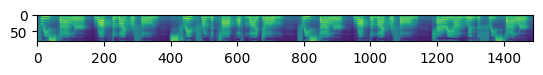

In [41]:
with torch.no_grad():
    mels, mel_lens, *_ = fp(batch, use_gt_durations=True, use_gt_pitch=True)
    mels = mels.permute(0, 2, 1)
    audio = hfg(mels)

Ipd.display(Ipd.Audio(audio.squeeze().cpu().detach().numpy(), rate=22050))
plt.imshow(mels.squeeze().cpu().detach().numpy())
plt.show()

In [42]:
batch = FastPitchBatch(
    texts=symbols_ids.unsqueeze(0),
    text_lengths=lengths,
    pitches=shift_pitch(pitch_pred, shift=0),
    durations=scale_durations(dur_pred, scale_factor=0.5)
).to(device)

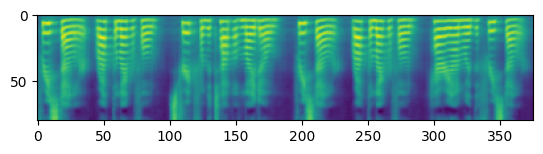

In [43]:
with torch.no_grad():
    mels, mel_lens, *_ = fp(batch, use_gt_durations=True, use_gt_pitch=True)
    mels = mels.permute(0, 2, 1)
    audio = hfg(mels)

Ipd.display(Ipd.Audio(audio.squeeze().cpu().detach().numpy(), rate=22050))
plt.imshow(mels.squeeze().cpu().detach().numpy())
plt.show()

In [44]:
batch = FastPitchBatch(
    texts=symbols_ids.unsqueeze(0),
    text_lengths=lengths,
    pitches=shift_pitch(pitch_pred, shift=50),
    durations=scale_durations(dur_pred, scale_factor=1)
).to(device)

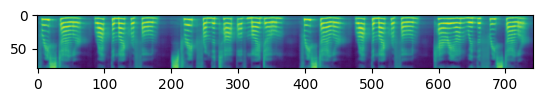

In [45]:
with torch.no_grad():
    mels, mel_lens, *_ = fp(batch, use_gt_durations=True, use_gt_pitch=True)
    mels = mels.permute(0, 2, 1)
    audio = hfg(mels)

Ipd.display(Ipd.Audio(audio.squeeze().cpu().detach().numpy(), rate=22050))
plt.imshow(mels.squeeze().cpu().detach().numpy())
plt.show()

In [46]:
batch = FastPitchBatch(
    texts=symbols_ids.unsqueeze(0),
    text_lengths=lengths,
    pitches=shift_pitch(pitch_pred, shift=-50),
    durations=scale_durations(dur_pred, scale_factor=1)
).to(device)

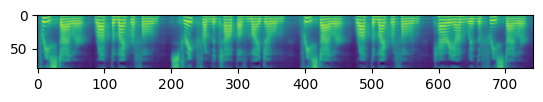

In [47]:
with torch.no_grad():
    mels, mel_lens, *_ = fp(batch, use_gt_durations=True, use_gt_pitch=True)
    mels = mels.permute(0, 2, 1)
    audio = hfg(mels)

Ipd.display(Ipd.Audio(audio.squeeze().cpu().detach().numpy(), rate=22050))
plt.imshow(mels.squeeze().cpu().detach().numpy())
plt.show()